# Deep Hedging AI
### Recurrent Network: impact of using recurrent networks on hedging forward started options

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-02-05 13:23:34.192265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 13:23:34.344009: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-02-05 13:23:36.011700: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-05 13:23:36.011742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-42-31.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-02-05 13:23:36.883041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


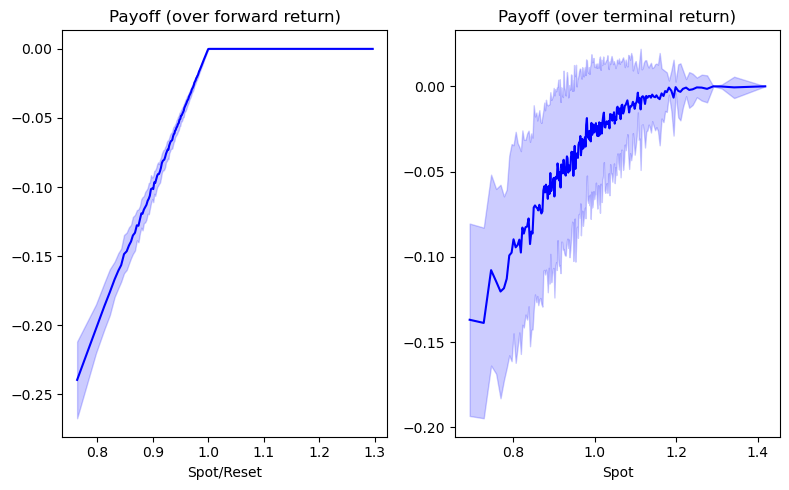

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from cdxbasics.prettydict import PrettyOrderedDict as pdct
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.steps = 20
#config.world.dt    = 1./50.
iReset = 10

nBins = 200

def fwd_start( spots ):
    terminal   = np.maximum( 1. * spots[:,iReset] - spots[:,-1], 0. )  # put
    return -terminal

config.world.samples = 20000
config.world.drift = 0.
config.world.cost_s = 0.
config.world.black_scholes = True
config.world.payoff = fwd_start
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 5
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence   = 5 # continuous recurrent nodes
config.gym.agent.recurrence01 = 5 # digital recurrent nodes
config.gym.agent.recurrence_gru = True # digital recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 0.9
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = config.world("samples")
config.trainer.train.epochs = 25000
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_recurrent = config.copy()

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)
gyms = pdct()

# plot
from deephedging.base import npCast, mean_bins
from cdxbasics.dynaplot import figure
import numpy as np

payoff = world.data.market.payoff
spots  = world.details.spot_all
fig = figure()
ax = fig.add_subplot()

ref  = spots[:,-1] / spots[:,iReset]
ixs  = np.argsort(ref)
xm   = mean_bins( ref[ixs], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( payoff[ixs], bins=nBins, weights=world.sample_weights, return_std = True )

ax.plot( xm, m, color="blue")
ax.set_title("Payoff (over forward return)")
ax.set_xlabel("Spot/Reset")
ax.fill_between( xm, m-s,m+s, color="blue",alpha=0.2)

ax = fig.add_subplot()

ref  = spots[:,-1]
ixs  = np.argsort(ref)
xm   = mean_bins( ref[ixs], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( payoff[ixs], bins=nBins, weights=world.sample_weights, return_std = True )

ax.plot( xm, m, color="blue")
ax.set_title("Payoff (over terminal return)")
ax.set_xlabel("Spot")
ax.fill_between( xm, m-s,m+s, color="blue",alpha=0.2)

fig.close()



## Hedging a forward started put with recurrence

Gym with 2414 trainable weights compiled and initialized. Took 3s
Agent is using 2412 weights: 2401 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cec45223458488a41979b77b40daf66a50e822c0149303ba.pck'


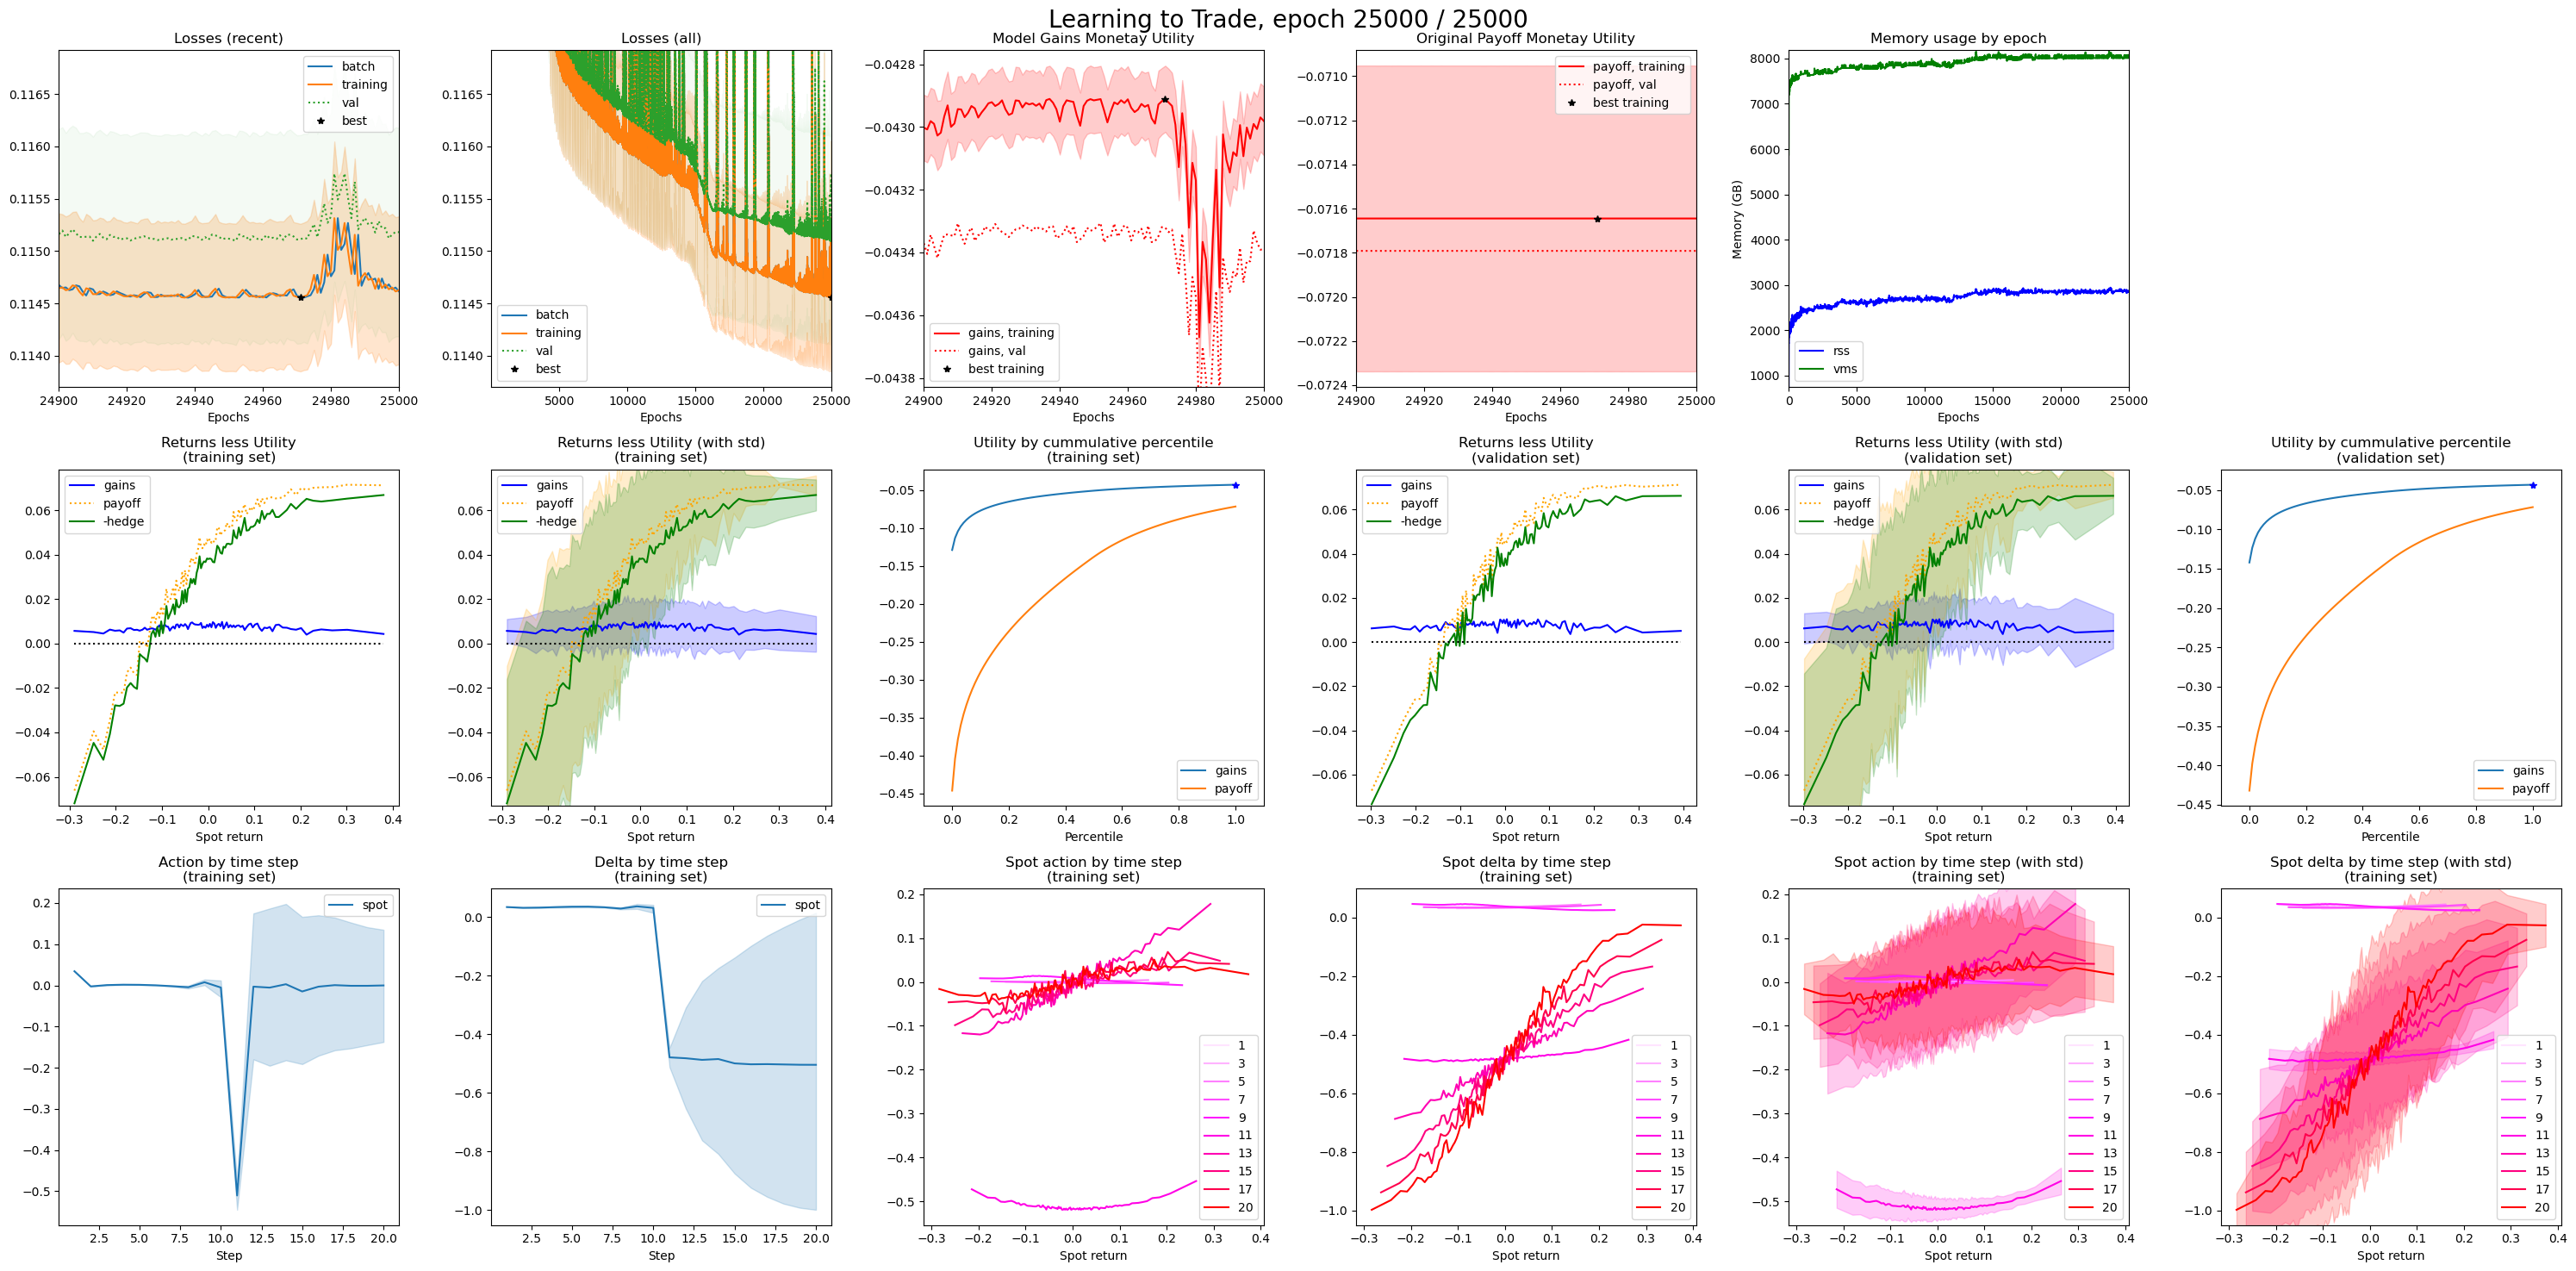

Training 25000/25000 epochs; 2414 weights; 20000 samples; 10000 validation samples batch size 20000 | initial loss 0.356533 (0.00288156), training 0.114625 (0.000706646), best 0.114555 (0.00288156), batch 0.114614, val 0.115181 (0.000997156). Best epoch 24971; last cached 25000. | memory used: rss 2872.94M, vms 8076.12M | time elapsed 3:36:09; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 24971
 State of training until epoch 25000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cec45223458488a41979b77b40daf66a50e822c0149303ba.pck

Training terminated. Total time taken 8s


In [3]:
# train
display(Markdown("## Hedging a forward started put with recurrence"))
gyms.recurrent_gru = VanillaDeepHedgingGym( config.gym )
train( gym=gyms.recurrent_gru, world=world, val_world=val_world, config=config.trainer )
config.done()

## Hedging a forward started put without GRU

Gym with 2204 trainable weights compiled and initialized. Took 1s
Agent is using 2202 weights: 2191 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/256d25a19941d231bfeaa25df6bb9ab7477b28b17d189dee.pck'


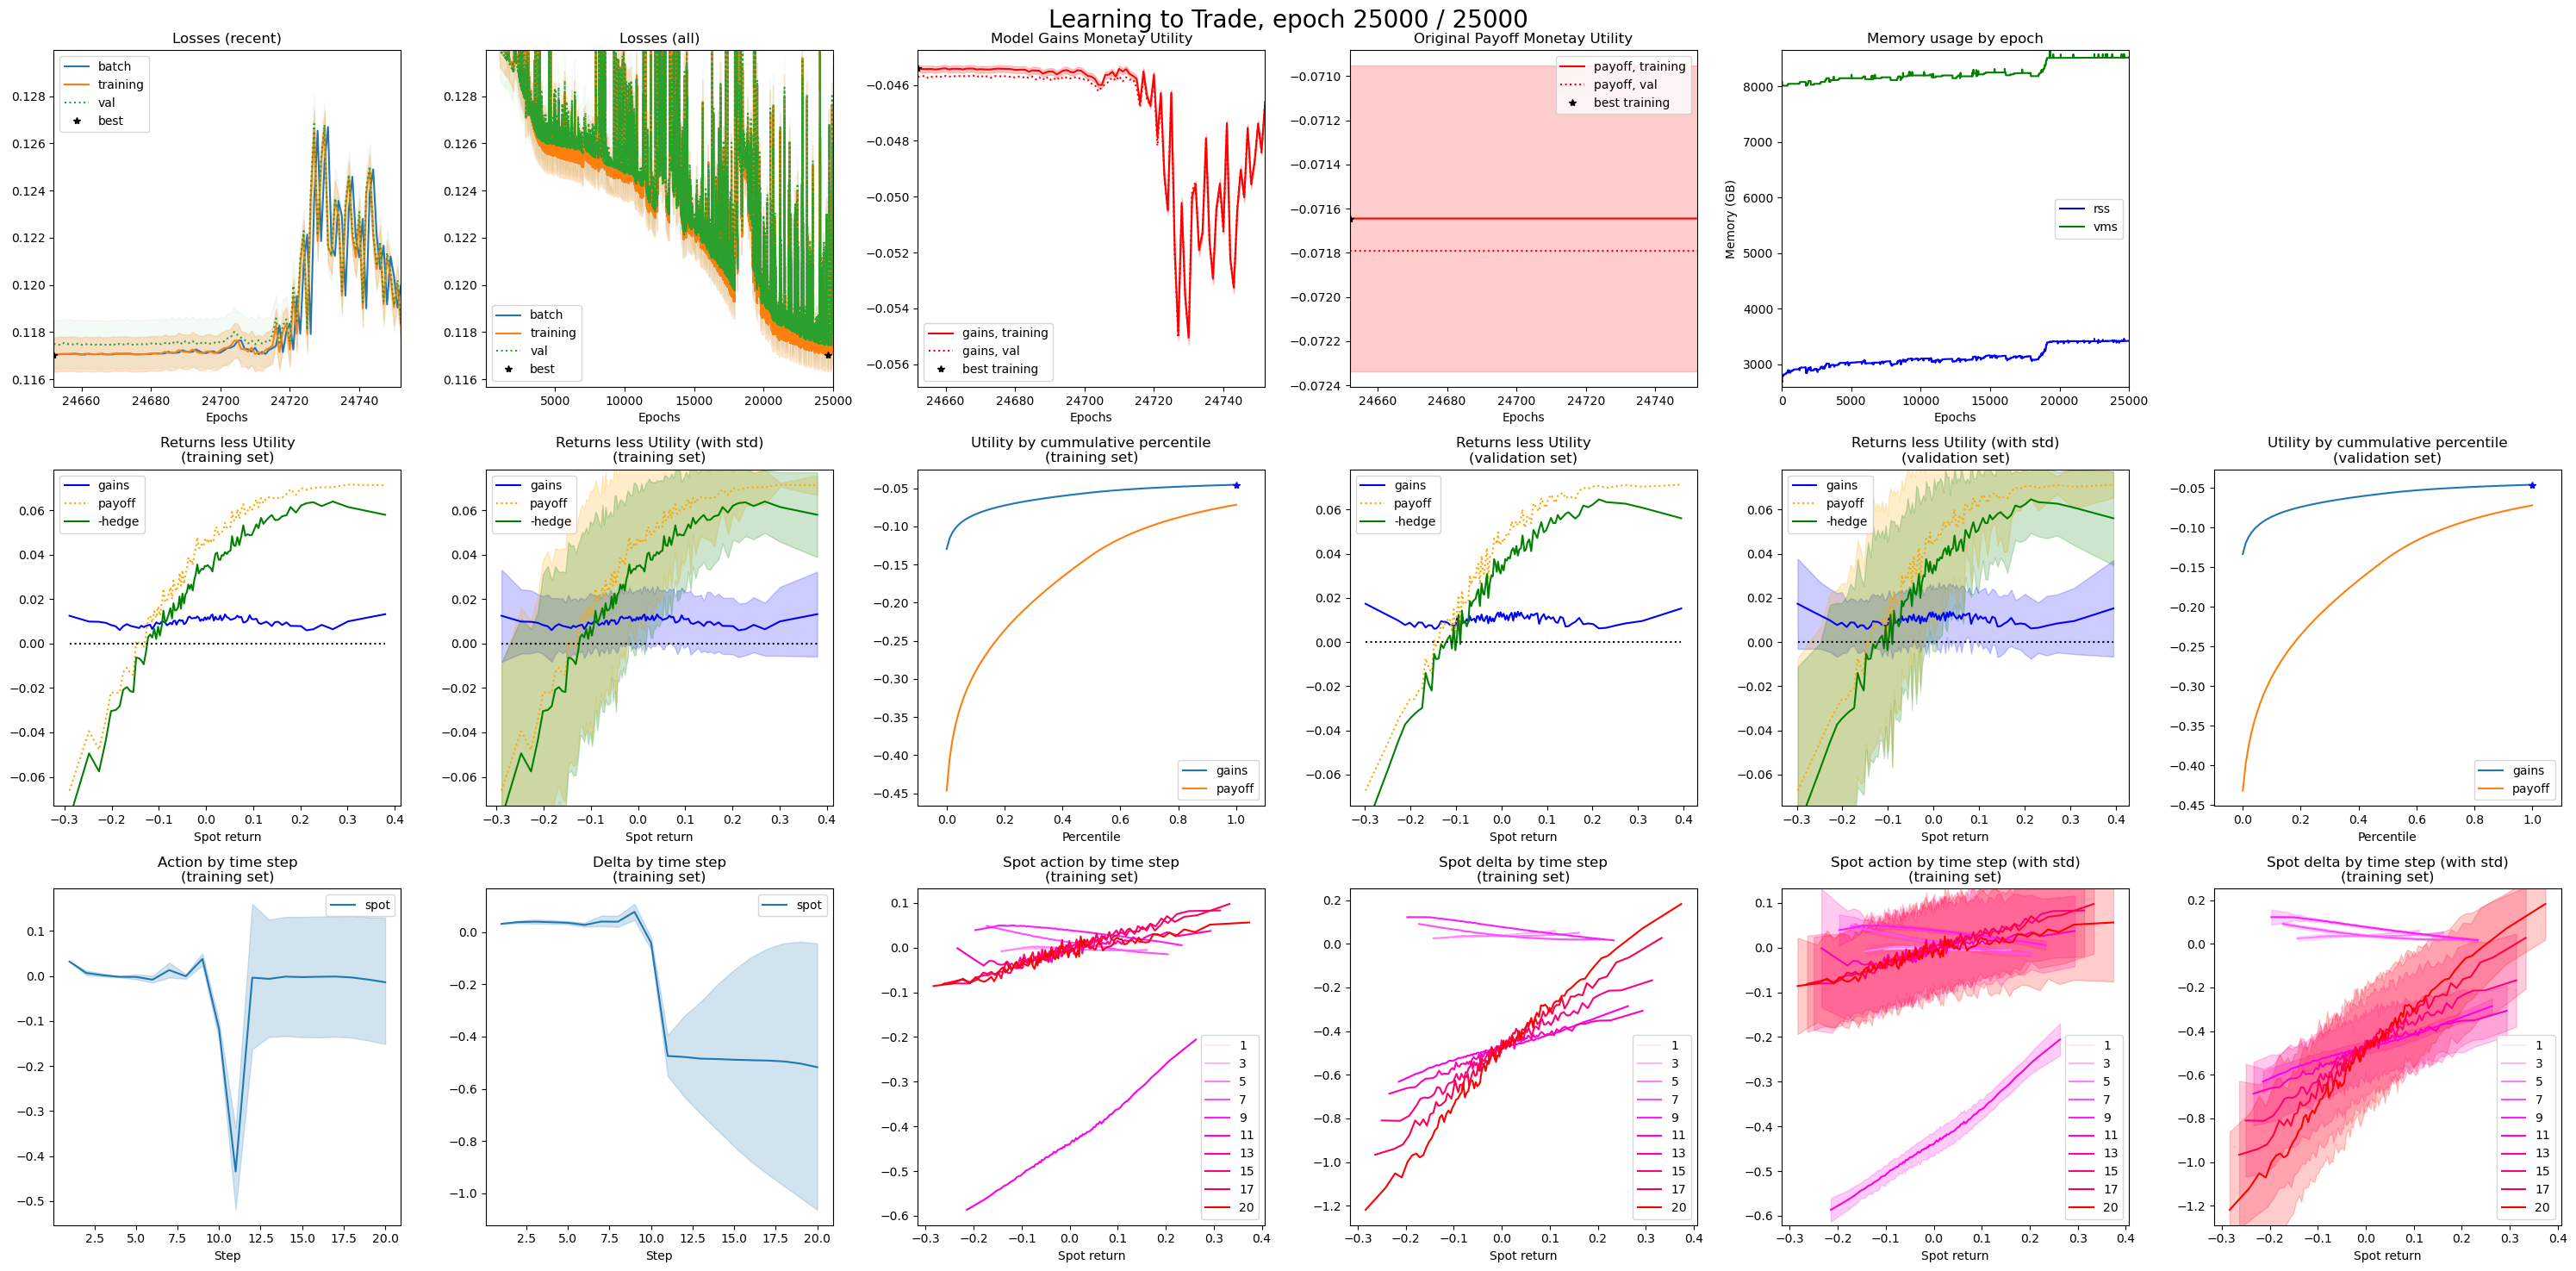

Training 25000/25000 epochs; 2204 weights; 20000 samples; 10000 validation samples batch size 20000 | initial loss 0.234758 (0.00157119), training 0.117597 (0.000726833), best 0.117045 (0.00157119), batch 0.117496, val 0.117842 (0.00102639). Best epoch 24652; last cached 25000. | memory used: rss 3417.22M, vms 8515.12M | time elapsed 3:07:28; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 24652
 State of training until epoch 25000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/256d25a19941d231bfeaa25df6bb9ab7477b28b17d189dee.pck

Training terminated. Total time taken 9s


In [4]:
config = config_recurrent.copy()
config.gym.agent.recurrence_gru = False # digital recurrent nodes
config.world.mark_done()

# train
display(Markdown("## Hedging a forward started put without GRU"))
gyms.recurrent = VanillaDeepHedgingGym( config.gym )
train( gym=gyms.recurrent, world=world, val_world=val_world, config=config.trainer )
config.done()

## Hedging a forward started put without recurrence

Gym with 1784 trainable weights compiled and initialized. Took 1s
Agent is using 1782 weights: 1781 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/33e4bd7a73f321f4205a09d7104f575671958a21f0c6dfd8.pck'
Cache successfully loaded. Current epoch: 25000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/33e4bd7a73f321f4205a09d7104f575671958a21f0c6dfd8.pck was

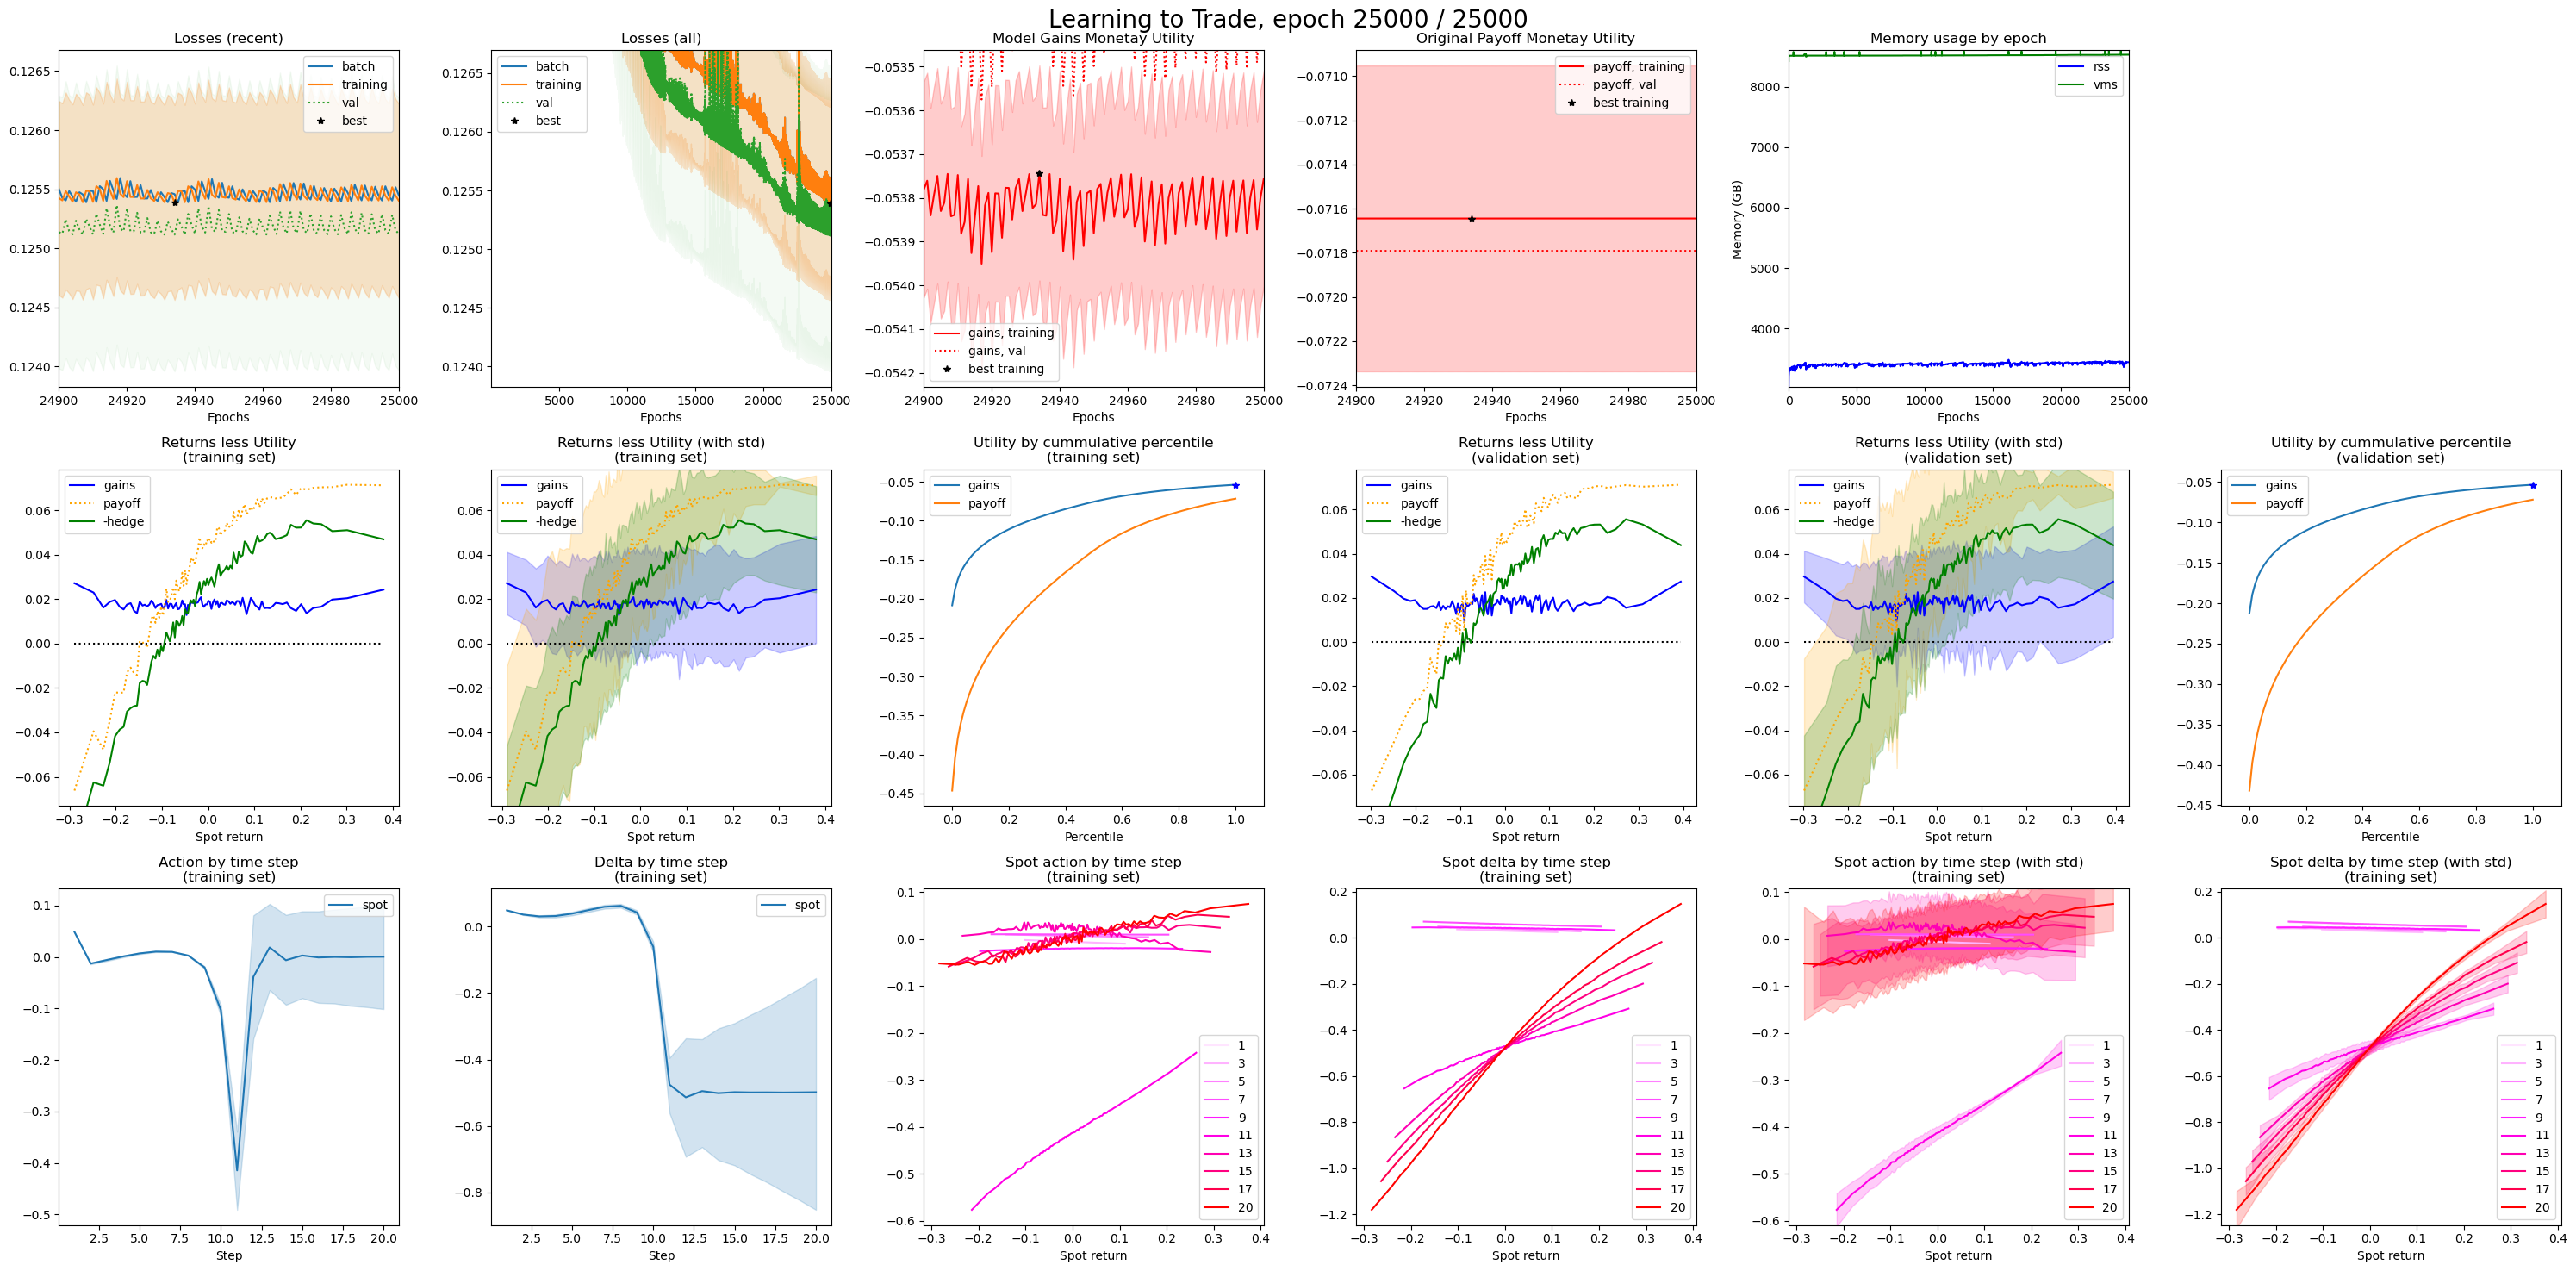

Training 25000/25000 epochs; 1784 weights; 20000 samples; 10000 validation samples batch size 20000 | initial loss 0.437344 (0.0037681), training 0.1254 (0.000821921), best 0.125388 (0.0037681), batch 0.125446, val 0.125122 (0.00115436). Best epoch 24934; last cached 25000. | memory used: rss 3442.32M, vms 8528.09M | time elapsed 2:39:08; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 24934
 State of training until epoch 25000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/33e4bd7a73f321f4205a09d7104f575671958a21f0c6dfd8.pck

Training terminated. Total time taken 10s


In [5]:
config = config_recurrent.copy()
config.gym.agent.recurrence   = 0 # continuous recurrent nodes
config.gym.agent.recurrence01 = 0 # digital recurrent nodes
config.world.mark_done()
# train
display(Markdown("## Hedging a forward started put without recurrence"))
gyms.normal = VanillaDeepHedgingGym( config.gym )
train( gym=gyms.normal, world=world, val_world=val_world, config=config.trainer )
config.done()

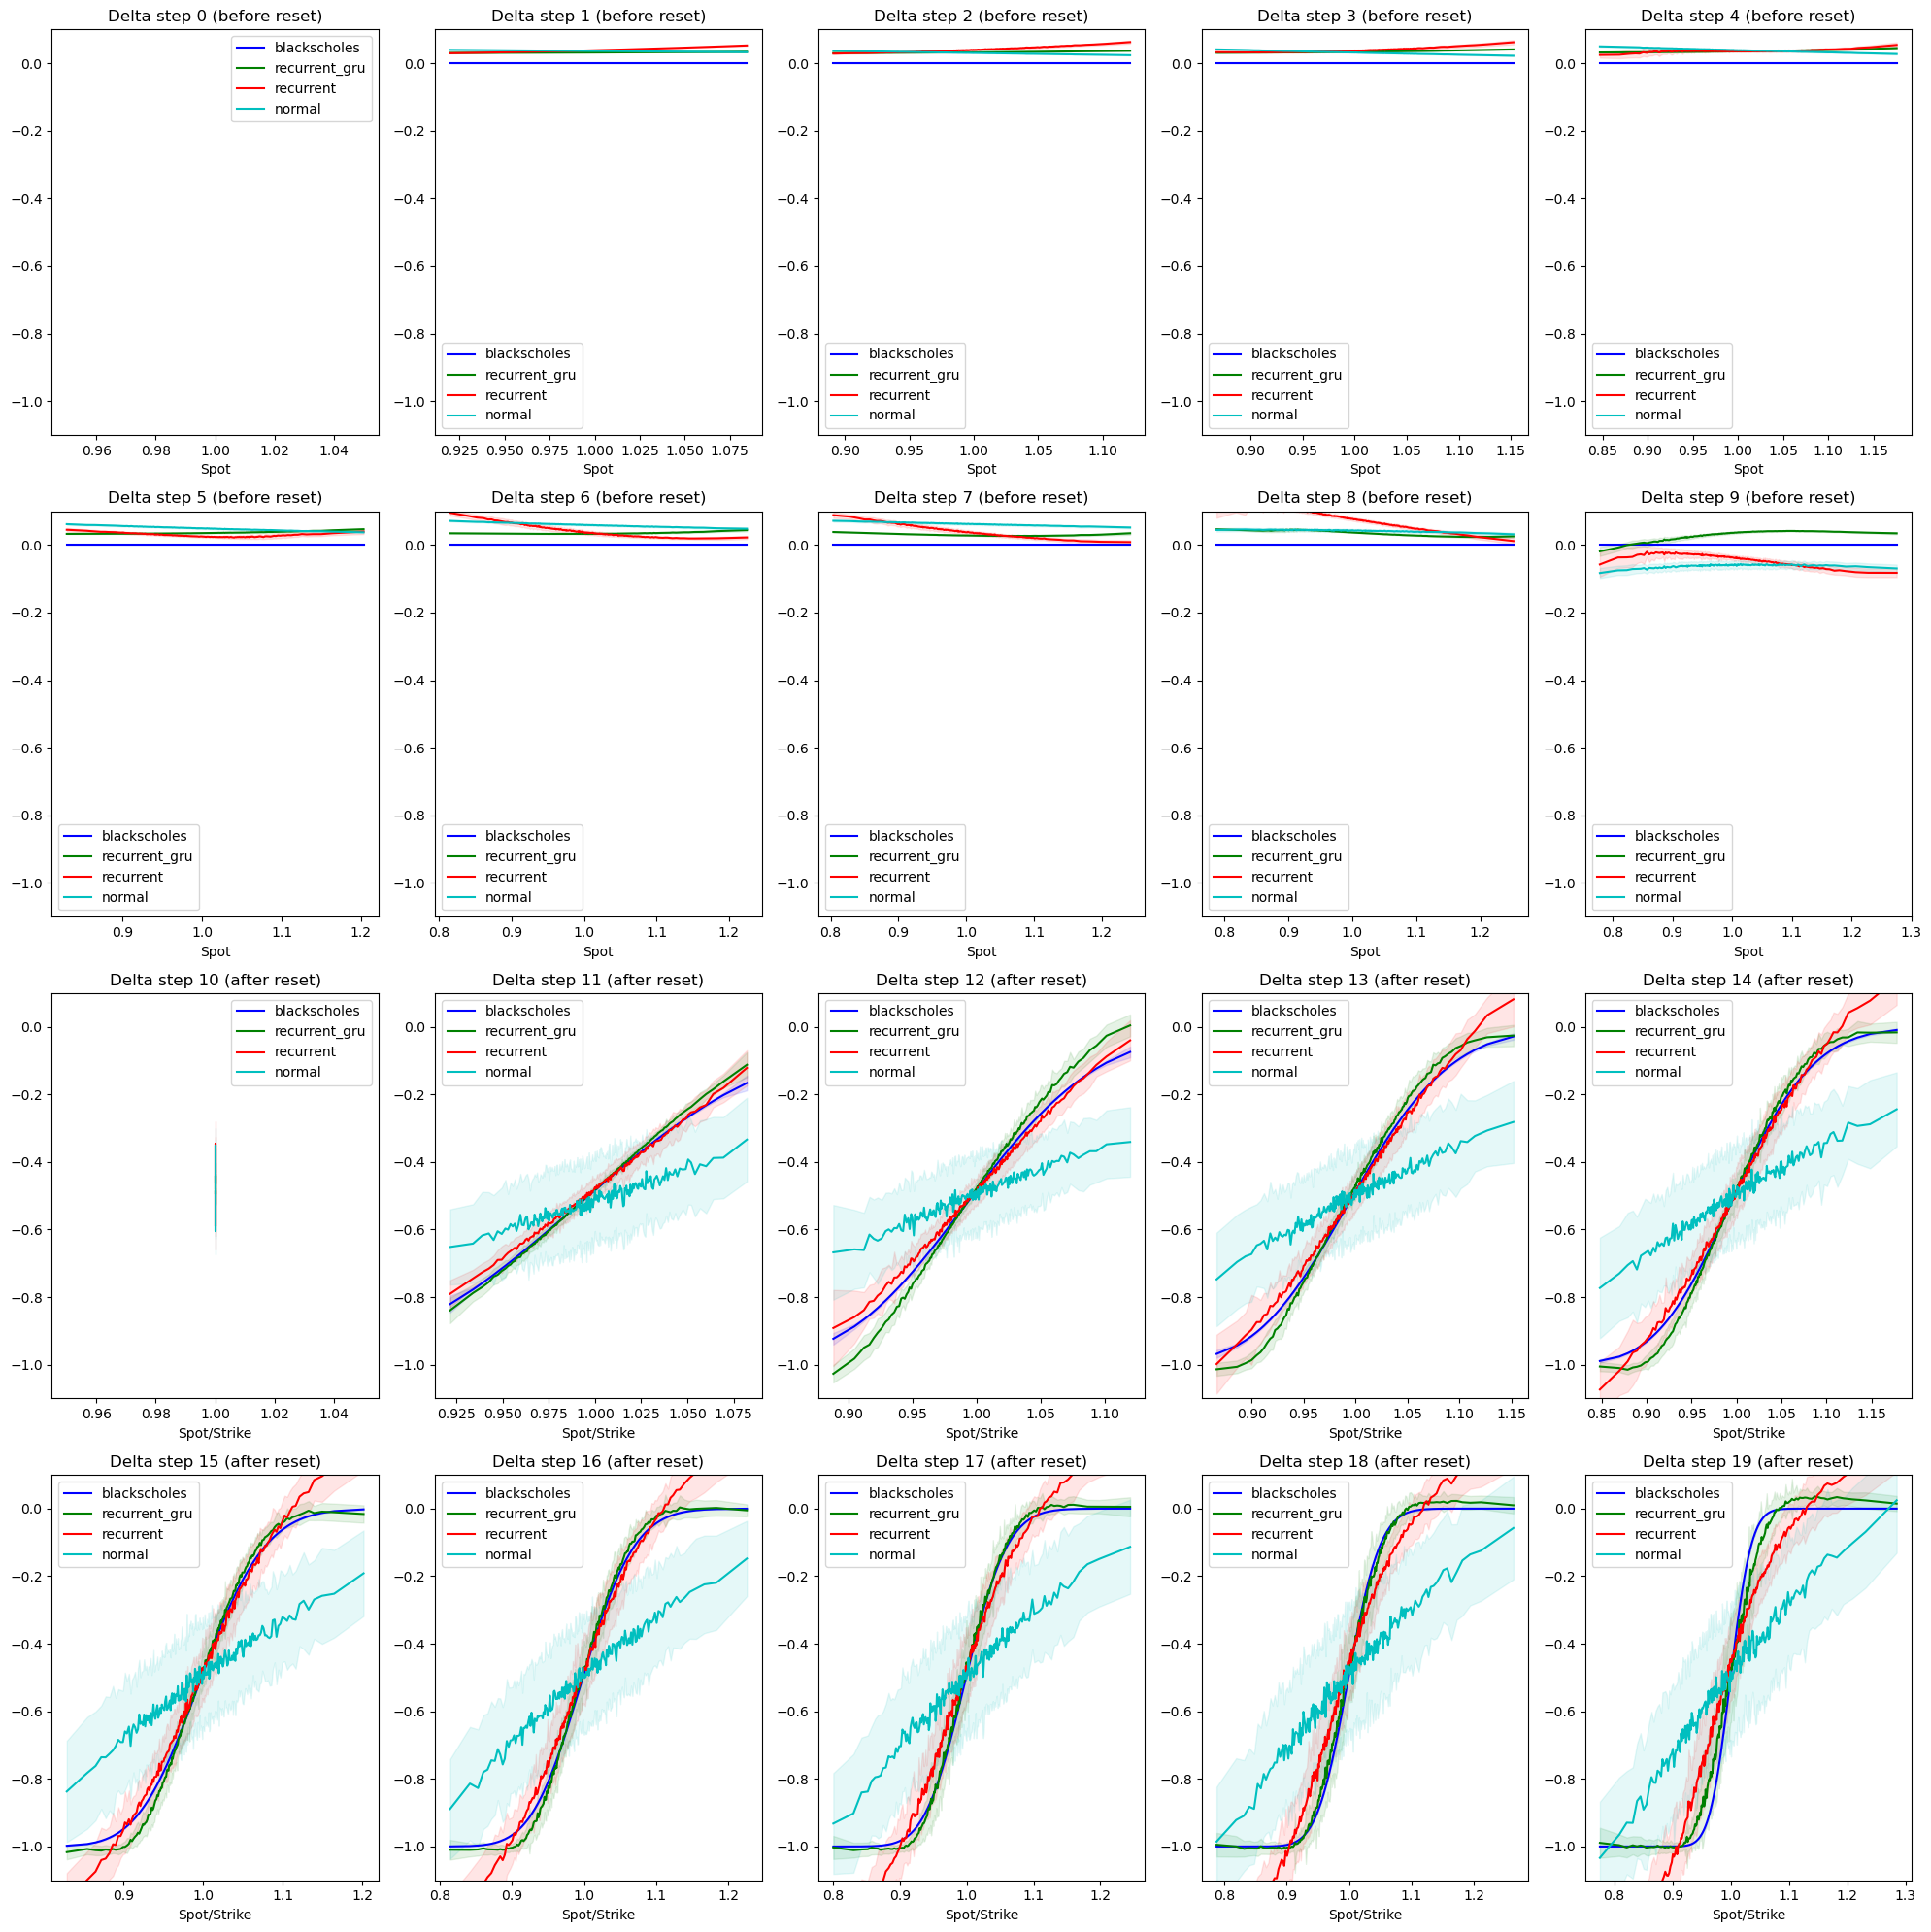

## Forward Starting Option Hedging

## Terminal Profiles

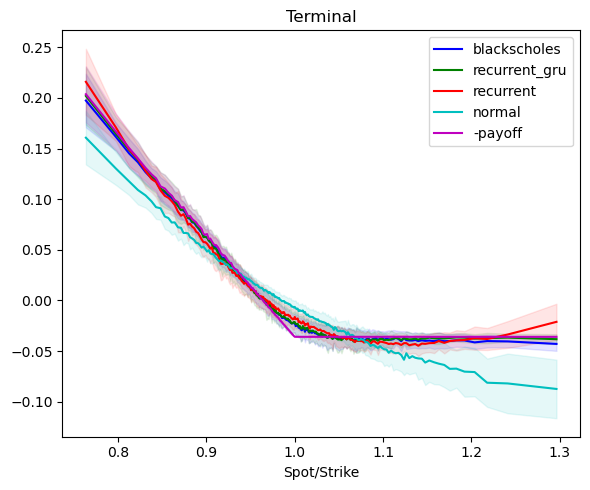

In [6]:
from deephedging.base import npCast, mean_bins
from cdxbasics.dynaplot import figure, colors_base
from scipy.stats import norm
import math as math
import numpy as np

spots      = world.details.spot_all
hedges     = world.data.market.hedges[:,:,0]
time_left  = world.data.features.per_step.time_left[0,:]
nSteps     = world.nSteps
nSamples   = world.nSamples
nBins     = 200

results = { k: npCast( gyms[k](world.tf_data) ) for k in gyms }
actions = { k: results[k]['actions'][:,:,0] for k in gyms }
deltas  = { k: np.cumsum( actions[k], axis=1) for k in gyms }

nBinSteps = 7
ixs       = np.linspace(0,nSteps,nBinSteps,endpoint=True,dtype=np.int32)
vol       = config.world.get_raw("rvol", 0.2)

pnls      = { k: np.zeros((nSamples,)) for k in gyms }
pnls['blackscholes'] = np.zeros((nSamples,))
prev_deltas_t  = { k: 0. for k in pnls }

keys_sorted = ['blackscholes'] + list( gyms.keys() )

fig = figure()
display(Markdown("## Forward Starting Option Hedging"))

for j in range(nSteps):
    ax_delta  = fig.add_subplot()
    ax_delta.set_ylim(-1.1,0.1)

    # sort by spot at j, and compute BS refernece
    spot_t    = spots[:,j]
    hedges_t  = hedges[:,j]   # S(T)-S(t_j)
    res_t     = time_left[j] 

    # BS
    # note that the 'drift' in the simulator is the statistical drift, not the risk-neutral drift.
    if j<iReset:
        ref_spot       = spot_t
        bsdelta_t      = ref_spot*0.
        ax_delta.set_title("Delta step %ld (before reset)" % j)
        ax_delta.set_xlabel("Spot")
    else:
        strike        = spots[:,iReset]
        d1            = ( np.log(spot_t/strike) +  0.5 * vol * vol  * res_t ) / math.sqrt( res_t * vol * vol )
        d2            = d1 - vol * math.sqrt( res_t )
        N1            = norm.cdf(d1)
        N2            = norm.cdf(d2)
        bsprice_t     = spot_t * N1 - strike * N2      # call
        bsprice_t     = bsprice_t + strike - spot_t    # C=P+S-K
        bsdelta_t     = N1
        bsdelta_t     = bsdelta_t - 1.
        ref_spot      = spot_t/strike
        ax_delta.set_title("Delta step %ld (after reset)" % j)
        ax_delta.set_xlabel("Spot/Strike")
        
    deltas_t  = { k: deltas[k][:,j] for k in deltas }
    deltas_t['blackscholes'] = bsdelta_t
    actions_t = { k: deltas_t[k] - prev_deltas_t[k] for k in deltas_t }
    dS_t      = spots[:,j+1] - spot_t
    pnls      = { k: pnls[k] + actions_t[k] * dS_t for k in pnls }

    # plot
    ixs       = np.argsort(ref_spot)
    ref_spot  = ref_spot[ixs]
    deltas_t  = { k: deltas_t[k][ixs] for k in deltas_t }
    
    x_mean          = mean_bins( ref_spot, bins=nBins, weights=world.sample_weights, return_std = False )
    colors          = colors_base()
    for k in keys_sorted:
        mean, std = mean_bins( deltas_t[k], bins=nBins, weights=world.sample_weights, return_std = True )
        color     = next(colors)
        ax_delta.plot( x_mean, mean, label=k, color=color)
        ax_delta.fill_between( x_mean, mean-std, mean+std, color=color, alpha=0.1 )

    ax_delta.legend()
    
fig.close()

# terminal
display(Markdown("## Terminal Profiles"))

spots    = world.details.spot_all
payoff   = world.data.market.payoff
payoff   = payoff - np.mean( payoff )

spot_ret = spots[:,-1] / spots[:,iReset]
ixs      = np.argsort(spot_ret)
spot_ret = spot_ret[ixs]
pnls     = { k : pnls[k][ixs] for k in pnls }
payoff   = payoff[ixs]

spot_mean = mean_bins( spot_ret, bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff, bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=6)
ax = fig.add_subplot()
ax.set_title("Terminal")
ax.set_xlabel("Spot/Strike")

colors = colors_base()
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )

color = next(colors)
ax.plot( spot_mean, -payoff_mean, label="-payoff", color=color)
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
ax.legend()
fig.close()
